In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

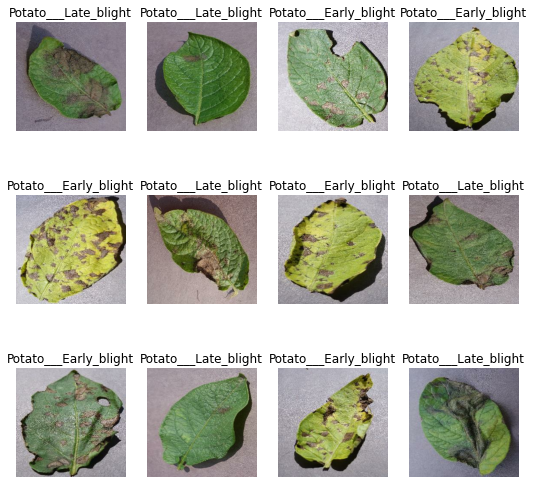

In [18]:
plt.figure(figsize=(9, 9))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

80% ==> training
20% ==> 10% validation, 10% testing before we deploy our model we use this 10% testing data

In [19]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [20]:
train_ds = dataset.take(54)
len(train_ds)

54

In [21]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [22]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [23]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [24]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [35]:
## Train test split

In [25]:
def get_dataset_partition_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [26]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [27]:
len(train_ds)

54

In [28]:
len(val_ds)

6

In [29]:
len(test_ds)

8

In [32]:
## cache and prefetch increase the training speed

In [30]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
# Resize and Rescale the images

In [31]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [34]:
# Data Augmentation preformed

In [36]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [39]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(n_classes, activation = 'softmax'),
])
model.build(input_shape=input_shape)

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (256, 256, 3)             0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (32, 60, 60, 64)         

In [41]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [42]:
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 297s 5s/step - loss: 0.9432 - accuracy: 0.5070 - val_loss: 1.0617 - val_accuracy: 0.4531
Epoch 2/50
54/54 [==============================] - 235s 4s/step - loss: 0.7262 - accuracy: 0.6345 - val_loss: 0.4590 - val_accuracy: 0.8281
Epoch 3/50
54/54 [==============================] - 192s 4s/step - loss: 0.4226 - accuracy: 0.8199 - val_loss: 0.3592 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - 191s 4s/step - loss: 0.2833 - accuracy: 0.8877 - val_loss: 0.5894 - val_accuracy: 0.8073
Epoch 5/50
54/54 [==============================] - 196s 4s/step - loss: 0.3129 - accuracy: 0.8772 - val_loss: 0.1879 - val_accuracy: 0.9375
Epoch 6/50
54/54 [==============================] - 198s 4s/step - loss: 0.2399 - accuracy: 0.9066 - val_loss: 0.2360 - val_accuracy: 0.8958
Epoch 7/50
54/54 [==============================] - 188s 3s/step - loss: 0.1932 - accuracy: 0.9251 - val_loss: 0.1789 - val_accuracy: 0.9427
Epoch 8/50
54

54/54 [==============================] - 224s 4s/step - loss: 0.0130 - accuracy: 0.9955 - val_loss: 0.1272 - val_accuracy: 0.9688
Epoch 50/50
54/54 [==============================] - 228s 4s/step - loss: 0.0454 - accuracy: 0.9860 - val_loss: 0.0495 - val_accuracy: 0.9896


In [43]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 32s 817ms/step - loss: 0.0510 - accuracy: 0.9805


In [44]:
scores

[0.0509764738380909, 0.98046875]

In [45]:
history

In [46]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [48]:
history.history['accuracy']

[0.5497685074806213,
 0.6950231194496155,
 0.8414351940155029,
 0.8912037014961243,
 0.8998842835426331,
 0.9108796119689941,
 0.9340277910232544,
 0.9195601940155029,
 0.9241898059844971,
 0.9490740895271301,
 0.9502314925193787,
 0.9438657164573669,
 0.9641203880310059,
 0.9612268805503845,
 0.9664351940155029,
 0.9722222089767456,
 0.9826388955116272,
 0.9791666865348816,
 0.9594907164573669,
 0.9780092835426331,
 0.9756944179534912,
 0.9849537014961243,
 0.9716435074806213,
 0.9791666865348816,
 0.9785879850387573,
 0.9884259104728699,
 0.984375,
 0.9785879850387573,
 0.9785879850387573,
 0.9878472089767456,
 0.9924768805503845,
 0.9913194179534912,
 0.9930555820465088,
 0.984375,
 0.9913194179534912,
 0.9918981194496155,
 0.9913194179534912,
 0.9855324029922485,
 0.9890046119689941,
 0.9907407164573669,
 0.9942129850387573,
 0.9861111044883728,
 0.9907407164573669,
 0.9797453880310059,
 0.9936342835426331,
 0.9930555820465088,
 0.9913194179534912,
 0.9907407164573669,
 0.996527791

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS = 50

Text(0.5, 1.0, 'Training and Validation Accuracy')

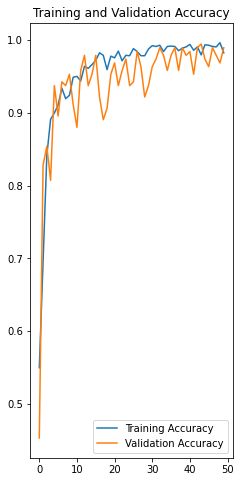

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

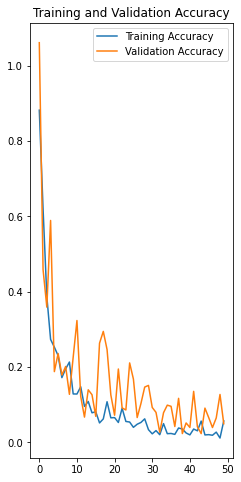

In [54]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Accuracy')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Accuracy')

first image to predict
actual label: Potato___Early_blight
Potato___Early_blight


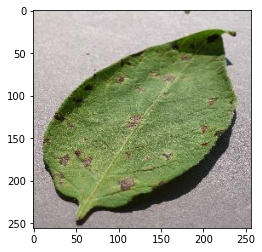

In [61]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label:', class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [57]:
model.save('potato_model')

INFO:tensorflow:Assets written to: potato_model\assets


In [67]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

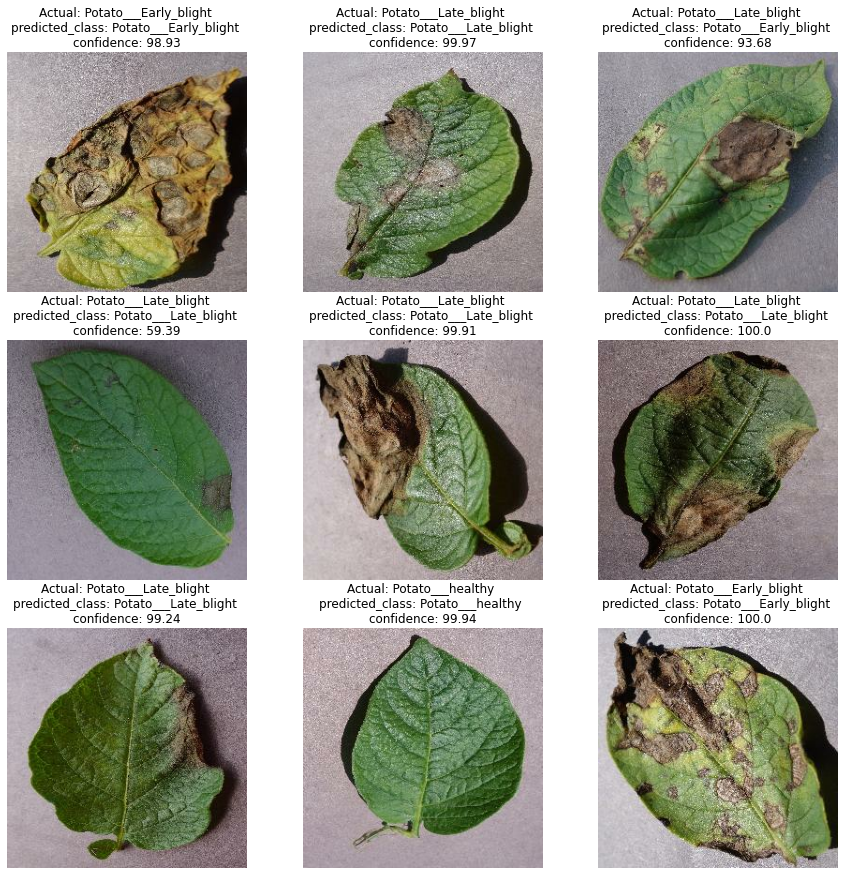

In [70]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_label = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_label} \npredicted_class: {predicted_class} \nconfidence: {confidence}")
        plt.axis('off')